# **Airline Performance - Does the Market Care?**

As a passenger flying aboard one of the US' top airlines, it may be assumed that one of your priorities is the efficiency and timeliness of your flight; that is, that it departs on time, and arrives to your destination either on time or earlier. It may then be assumed that an airline's market price would fluctuate according to its ability to accomplish this task. However, in today's cutthroat airline market, there are numerous other factors that may affect an airline's market price such as loyalty programs, access to airport lounges, the overall travel network, and the passenger experience as a whole. So, does airline operational efficiency actually correlate with market prices, or do these other factors outweigh the occasional delay? If these metrics do affect the market price, by how much? This information is useful for airlines deciding how they should prioritize and allocate resources.

Here, we will look at the year 2024 so that we can work with an entire year's data, and see how the operational efficiency of the US' top four airlines (as measured by market-cap) correlates to their market prices. To do this, we will use data from the publicly-available consumer reports published by the Department of Transportation (DOT) and published stock prices gathered from the yfinance API which uses Yahoo! Finance as its source.


## 1. Data Acquisition and Cleaning


In [15]:
#import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
#from: https://ranaroussi.github.io/yfinance/
import warnings
warnings.filterwarnings('ignore')
# from Claude AI (the first code block below was generating Future Warnings even though the code worked. I asked the AI how to remove them.

The top four US airlines were determined by ranking their market cap as reported by Yahoo! Finance (https://finance.yahoo.com/sectors/industrials/airlines/?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAFxky9cRLJ9G522vMRzJH9Xxn8m4flB1-DD2wyDdGqlNPsiqMKlZDp0AUx1UqeV9R-qMh4yucet9bomUYk6w5LLrg9GJCYNmwcvNetGlckaiaYa1cgIPVpHtP_NJ9rqDpHcs9UoudQs_o9zDm_mheR17fI2ZbEddx_zWC2HzYVI9/).

In [16]:
# Top four airline stock tickers:

airline_tickers = {'Delta': 'DAL','United': 'UAL','American': 'AAL','Southwest': 'LUV'}
# airline_tickers = yf.Tickers('DAL UAL LUV AAL')
# code syntax from: https://ranaroussi.github.io/yfinance/

# Gathering stock data from top four airlines:
start_date = '2024-01-01'
end_date = '2024-12-31'

# stock_data = yf.download(['DAL', 'UAL', 'LUV', 'AAL'], start=start_date, end=end_date, progress=False)
# if stock_data.empty:
#     print("Download error. Please try again.")
# else:
#     print("Stock data downloaded successfully.")

stock_data = {}
for airline, ticker in airline_tickers.items():
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    stock_data[airline] = df

# The commented out code from lines 4 and 11-15 were my own, however this created issues later when I tried to merge stock and on time percentage data.
# During troubleshooting with Claude AI, it suggested the code below as well as the dictionary of airline tickers seen on line 3.

Now that we've downloaded the airlines' stock information for 2024, let's display the raw data. Here, we'll see that we can see the daily closing price, highs, lows, open, and volume, per airline. Since it covers the entire year, there is quite a lot of information and it's not user-friendly to read (e.g. the values do not align with the column headers of close, high, etc.). Luckily for us, we are going to simplify this data by calculating the monthly average since the most granular on-time-percentage (OTP) data we have is also a monthly average.

In [17]:
# Displaying raw stock data:
print(stock_data)

{'Delta': Price           Close       High        Low       Open    Volume
Ticker            DAL        DAL        DAL        DAL       DAL
Date                                                            
2024-01-02  39.544373  40.023400  38.684074  39.075120   9483800
2024-01-03  37.872658  38.908923  37.804222  38.772058  11846200
2024-01-04  38.322361  38.791614  37.794450  37.872661   8355800
2024-01-05  39.632359  39.827882  38.185494  38.273480  11060000
2024-01-08  40.697956  41.157431  40.189598  40.306910  11967400
...               ...        ...        ...        ...       ...
2024-12-23  60.790020  60.829546  59.179360  59.880935   7196400
2024-12-24  61.817677  62.203048  60.542983  60.681321   3218400
2024-12-26  61.659576  62.104234  60.977761  61.264321   4478100
2024-12-27  60.533100  61.649693  60.325593  61.254441   7175400
2024-12-30  59.999508  60.454049  58.655645  59.456031   5153300

[251 rows x 5 columns], 'United': Price            Close        High        Low

In [18]:
# Process stock data to monthly averages
print("Processing stock data to monthly averages...\n")

monthly_stock = {}
for airline, df in stock_data.items():
    print(f"\n{airline}:")
    print(f"  Original df shape: {df.shape}")
    print(f"  Index type: {type(df.index)}")
    print(f"  First few dates: {df.index[:3]}")

    # Make sure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    monthly = df['Close'].resample('MS').mean()
    print(f"  After resample: {len(monthly)} months")
    print(f"  Monthly type: {type(monthly)}")
    print(f"  Monthly values: {monthly.head()}")

    monthly_stock[airline] = monthly

# Create DataFrame by concatenating along columns
stock_df = pd.concat(monthly_stock, axis=1)
stock_df.columns = list(monthly_stock.keys())  # Set column names to airline names
stock_df = stock_df.round(2)

print("\nMonthly Average Stock Prices (2024):")
print(stock_df)

# This block of code was generated using Claude AI. It was prompted with "How to calculate monthly stock averages after I've downloaded stock information using yFinance API."

Processing stock data to monthly averages...


Delta:
  Original df shape: (251, 5)
  Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
  First few dates: DatetimeIndex(['2024-01-02', '2024-01-03', '2024-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
  After resample: 12 months
  Monthly type: <class 'pandas.core.frame.DataFrame'>
  Monthly values: Ticker            DAL
Date                 
2024-01-01  38.519744
2024-02-01  39.912406
2024-03-01  43.057483
2024-04-01  46.845479
2024-05-01  50.886040

United:
  Original df shape: (251, 5)
  Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
  First few dates: DatetimeIndex(['2024-01-02', '2024-01-03', '2024-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
  After resample: 12 months
  Monthly type: <class 'pandas.core.frame.DataFrame'>
  Monthly values: Ticker            UAL
Date                 
2024-01-01  41.110000
2024-02-01  43.001500
2024-03-01  44.537500
2024-04-01  47.431363
2024-

Now that we have our stock data from the yFinance API, and it's arranged in a useful way (monthly averages), we now turn to look at our on-time-percentage (OTP) data. This data can be found on the US Department of Transportation's (DOT) website at https://www.transportation.gov/airconsumer/air-travel-consumer-report-archive. The US DOT publishes what are known as Air Travel Consumer Reports, or ATCRs. These reports are published monthly, and despite extensive research, is the only source of monthly OTP data sorted by airline. These reports are typically published 2-3 months after the month that they cover. For example, if you want to know information about December 2024, you would need to look at the February 2025 report. Because this information is only available via monthly pdfs, no web scrapping, API, or other programmatic data gathering solution was feasible. Instead, the 12 appropriate reports were manually downloaded and the airlines' OTP data was captured manually. Since we are looking at a fixed date range (2024), this will not be a problem.

In [19]:
otp_data = {
    'Month': pd.date_range(start='2024-01-01', periods=12, freq='MS'),
    'Delta': [77.8, 88.4, 84.8, 84.8, 79.8, 78.6, 67.6, 78.9, 87.2, 89.9, 88.6, 79.7],
    'United': [72.4, 83.2, 81.8, 81.3, 73.4, 75.8, 70.2, 76.2, 86.1, 87.7, 81.8, 79.5],
    'American': [73.9, 83.1, 76.6, 79.8, 71.4, 73.7, 70.6, 78.8, 85.0, 85.4, 86.9, 79.9],
    'Southwest': [70.5, 84.1, 77.5, 78.1, 66.3, 71.6, 65.7, 71.6, 81.6, 85.2, 84.2, 76.3]
}

otp_df = pd.DataFrame(otp_data)
otp_df = otp_df.set_index('Month')

print(otp_df)

# Lines 2, 9, and 10 were generated via Claude AI. I wasn't sure how to correlate the monthly OTP data to months and asked it how.

            Delta  United  American  Southwest
Month                                         
2024-01-01   77.8    72.4      73.9       70.5
2024-02-01   88.4    83.2      83.1       84.1
2024-03-01   84.8    81.8      76.6       77.5
2024-04-01   84.8    81.3      79.8       78.1
2024-05-01   79.8    73.4      71.4       66.3
2024-06-01   78.6    75.8      73.7       71.6
2024-07-01   67.6    70.2      70.6       65.7
2024-08-01   78.9    76.2      78.8       71.6
2024-09-01   87.2    86.1      85.0       81.6
2024-10-01   89.9    87.7      85.4       85.2
2024-11-01   88.6    81.8      86.9       84.2
2024-12-01   79.7    79.5      79.9       76.3


In [20]:
# Reshape OTP data from wide to long format for easier merging
otp_long = otp_df.reset_index().melt(
    id_vars='Month',
    var_name='Airline',
    value_name='OnTime_Percentage'
)

print("OTP data reshaped to long format:")
print(otp_long.head())

# Code was generated using Claude AI. I told the AI that I wanted to compare stock prices to OTP data and eventually show that visually. It generated this code block as well as others which will be individually cited.

OTP data reshaped to long format:
       Month Airline  OnTime_Percentage
0 2024-01-01   Delta               77.8
1 2024-02-01   Delta               88.4
2 2024-03-01   Delta               84.8
3 2024-04-01   Delta               84.8
4 2024-05-01   Delta               79.8


In [21]:
# Reshape stock data from wide to long format
stock_long = stock_df.reset_index().melt(
    id_vars='Date',
    var_name='Airline',
    value_name='Stock_Price'
)
stock_long = stock_long.rename(columns={'Date': 'Month'})

print("Stock data reshaped to long format:")
print(stock_long.head())

# Code was generated using Claude AI. I told the AI that I wanted to compare stock prices to OTP data and eventually show that visually. It generated this code block as well as others which will be individually cited.

Stock data reshaped to long format:
       Month Airline  Stock_Price
0 2024-01-01   Delta        38.52
1 2024-02-01   Delta        39.91
2 2024-03-01   Delta        43.06
3 2024-04-01   Delta        46.85
4 2024-05-01   Delta        50.89


In [22]:
# Merge stock and OTP data
combined_df = pd.merge(stock_long, otp_long, on=['Month', 'Airline'], how='inner')

# Remove missing values
combined_df = combined_df.dropna(subset=['Stock_Price', 'OnTime_Percentage'])

# Calculate additional metrics
combined_df['Delay_Percentage'] = 100 - combined_df['OnTime_Percentage']

print(f"\nCombined dataset: {len(combined_df)} records")
print(f"Airlines: {combined_df['Airline'].unique()}")
print(f"Months: {len(combined_df['Month'].unique())}")
print("\nFirst few rows:")
print(combined_df.head(10))

# Code was generated using Claude AI. I told the AI that I wanted to compare stock prices to OTP data and eventually show that visually. It generated this code block as well as others which will be individually cited.


Combined dataset: 48 records
Airlines: ['Delta' 'United' 'American' 'Southwest']
Months: 12

First few rows:
       Month Airline  Stock_Price  OnTime_Percentage  Delay_Percentage
0 2024-01-01   Delta        38.52               77.8              22.2
1 2024-02-01   Delta        39.91               88.4              11.6
2 2024-03-01   Delta        43.06               84.8              15.2
3 2024-04-01   Delta        46.85               84.8              15.2
4 2024-05-01   Delta        50.89               79.8              20.2
5 2024-06-01   Delta        48.69               78.6              21.4
6 2024-07-01   Delta        44.12               67.6              32.4
7 2024-08-01   Delta        39.40               78.9              21.1
8 2024-09-01   Delta        45.35               87.2              12.8
9 2024-10-01   Delta        52.50               89.9              10.1


In [23]:
# Summary statistics
print("Summary Statistics by Airline:")
print("="*70)

summary = combined_df.groupby('Airline').agg({
    'Stock_Price': ['mean', 'std', 'min', 'max'],
    'OnTime_Percentage': ['mean', 'min', 'max'],
    'Delay_Percentage': 'mean'
}).round(2)

print(summary)

# Code was generated using Claude AI. I told the AI that I wanted to compare stock prices to OTP data and eventually show that visually. It generated this code block as well as others which will be individually cited.

Summary Statistics by Airline:
          Stock_Price                      OnTime_Percentage              \
                 mean    std    min    max              mean   min   max   
Airline                                                                    
American        13.15   2.03   9.99  16.76             78.76  70.6  86.9   
Delta           47.72   7.85  38.52  61.89             82.18  67.6  89.9   
Southwest       28.76   2.25  25.71  32.80             76.06  65.7  85.2   
United          56.21  19.05  41.11  97.60             79.12  70.2  87.7   

          Delay_Percentage  
                      mean  
Airline                     
American             21.24  
Delta                17.82  
Southwest            23.94  
United               20.88  


## 2. Analysis and Visuals

Before get too deep on comparisons, let's first take an independent, visual look at both the stock trends for our airlines and then the OTP trends.

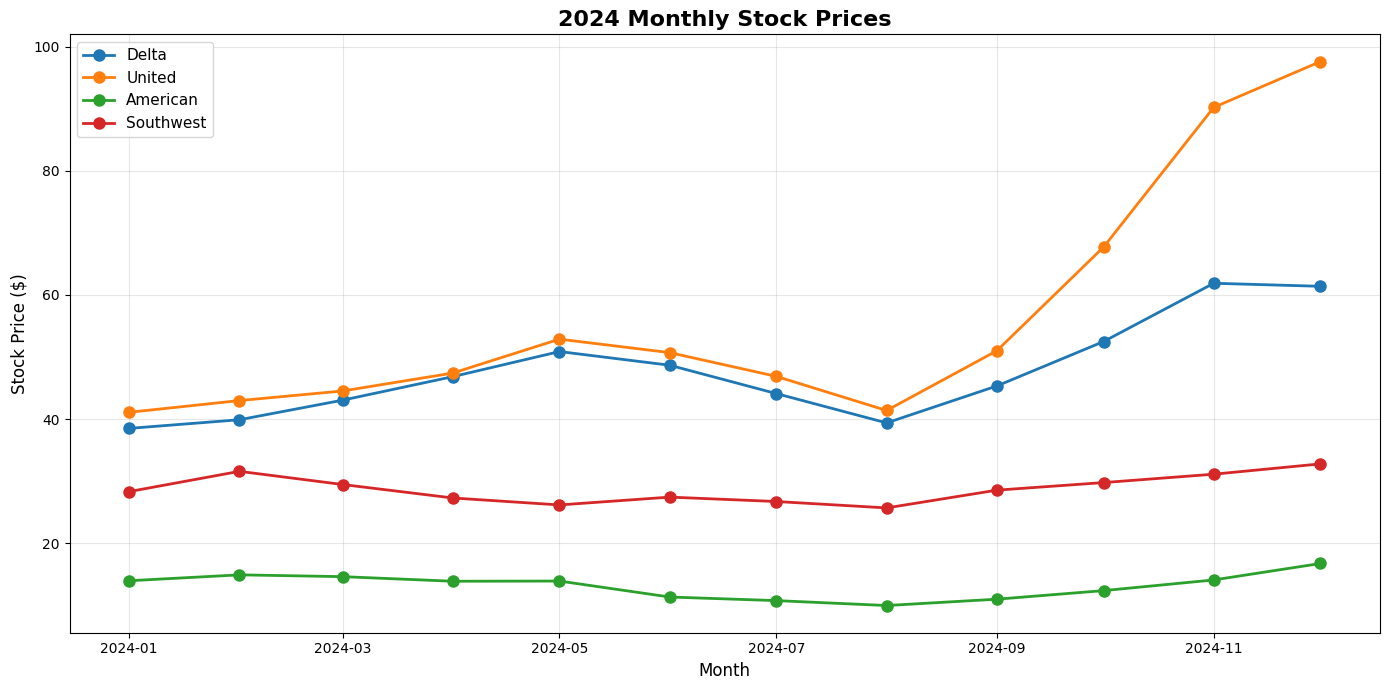

In [24]:
plt.figure(figsize=(14, 7))

for airline in airline_tickers.keys():
    data = combined_df[combined_df['Airline'] == airline]
    plt.plot(data['Month'], data['Stock_Price'],
             marker='o', linewidth=2, markersize=8, label=airline)

plt.title('2024 Monthly Stock Prices', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Stock Price ($)', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Here, we see relatively stable stock prices for all airlines with some fluctuation in the summer, and growth (to varying degrees) in the winter during the holiday travel season.

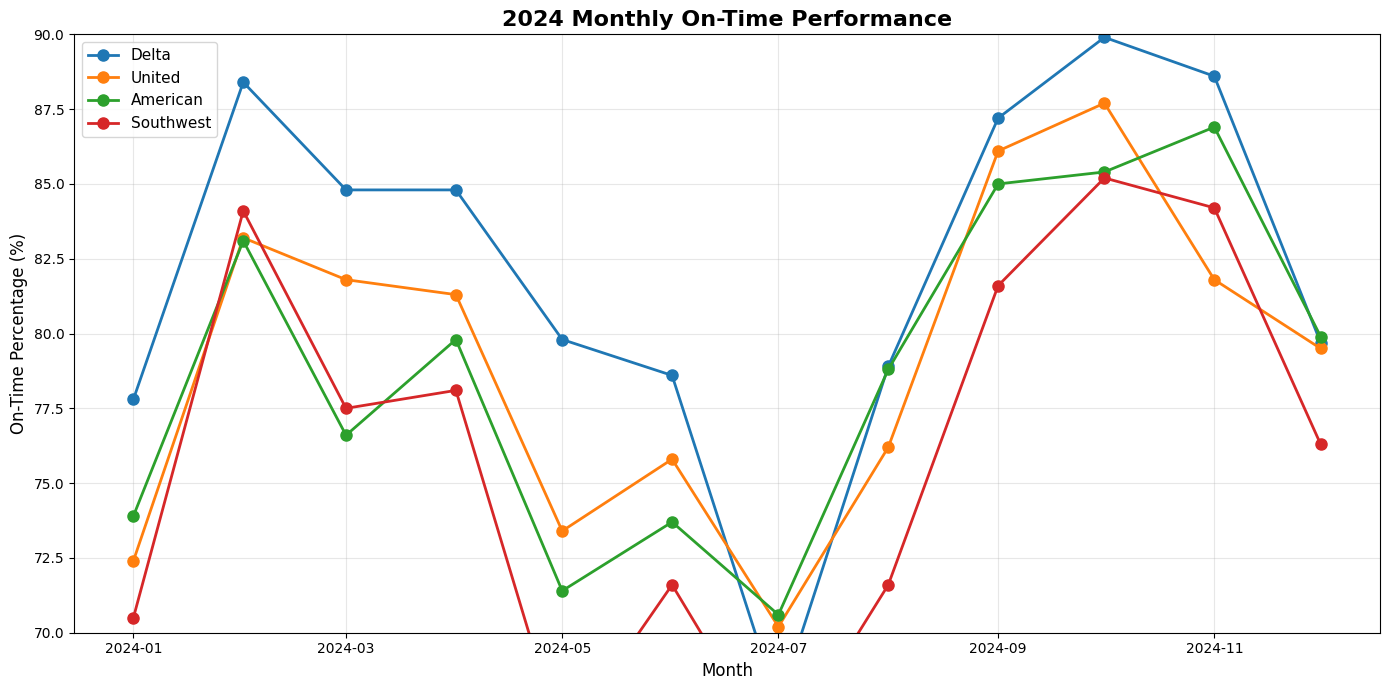

In [25]:
plt.figure(figsize=(14, 7))

for airline in airline_tickers.keys():
    data = combined_df[combined_df['Airline'] == airline]
    plt.plot(data['Month'], data['OnTime_Percentage'],
             marker='o', linewidth=2, markersize=8, label=airline)

plt.title('2024 Monthly On-Time Performance', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('On-Time Percentage (%)', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.ylim(70, 90)
plt.tight_layout()
plt.show()

Here, we see quite a bit of fluctuation. It is interesting to note that most airlines seem to peek and dip together, suggesting that operational delays affect airlines somewhat equally. Perhaps it is true that most delays are not caused by the airlines themselves, but instead by weather, air traffic control restrictions, etc.

Looking at these two graphs individually, it appears there is some sort of correlation, though it's far from perfect. We see a trend that both stock and OTP decline in the summer around July, and both begin to rise in the fall around September. However, they clearly differ in the winter where OTP declines while stocks remain high (perhaps because of the busy travel season, revenue is high, but winter weather and traffic congestion cause issues).

Now that we've seen the stock and OTP trends by themselves, let's layer them on top of each other so we can visually see if there's any correlation.

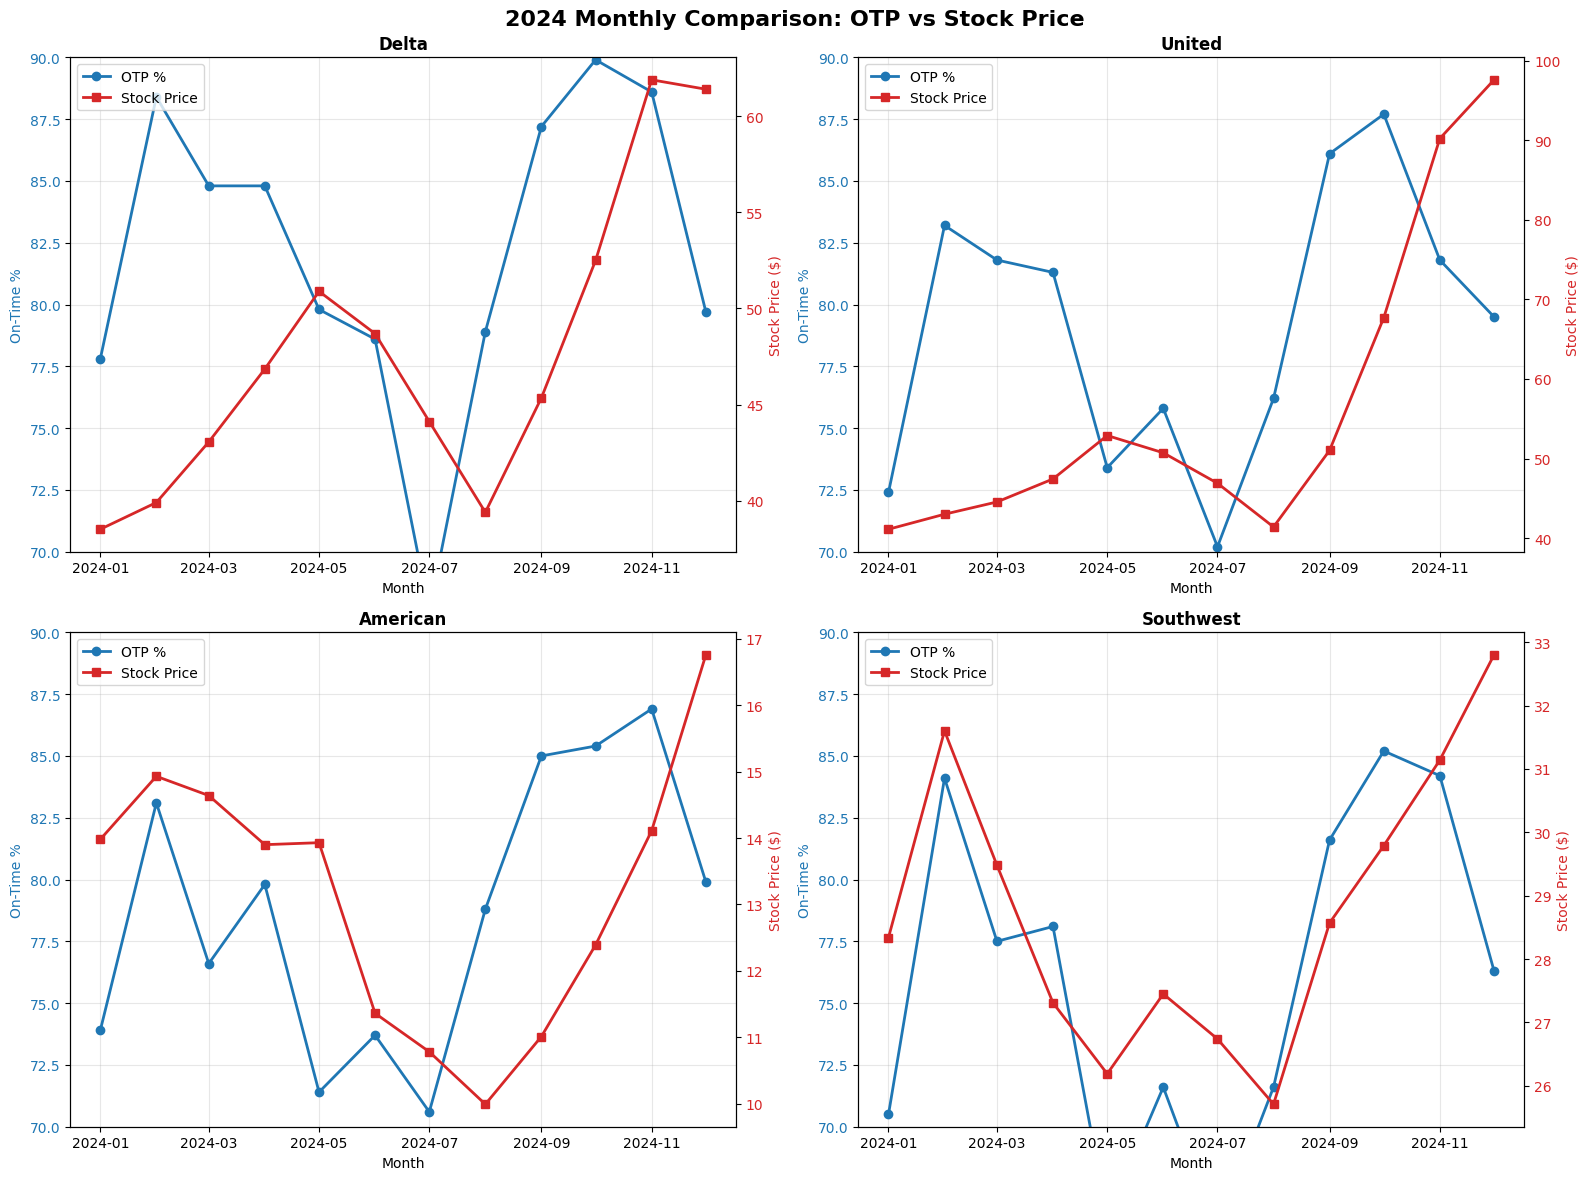

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('2024 Monthly Comparison: OTP vs Stock Price', fontsize=16, fontweight='bold')

for idx, airline in enumerate(airline_tickers.keys()):
    ax1 = axes[idx // 2, idx % 2]
    ax2 = ax1.twinx()

    data = combined_df[combined_df['Airline'] == airline].sort_values('Month')

    # OTP on left axis
    color1 = 'tab:blue'
    ax1.plot(data['Month'], data['OnTime_Percentage'],
             color=color1, marker='o', linewidth=2, label='OTP %')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('On-Time %', color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_ylim(70, 90)

    # Stock price on right axis
    color2 = 'tab:red'
    ax2.plot(data['Month'], data['Stock_Price'],
             color=color2, marker='s', linewidth=2, label='Stock Price')
    ax2.set_ylabel('Stock Price ($)', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    ax1.set_title(f'{airline}', fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

So, we've seen the stock and OTP trends over time and it appears there could be a correlation, but let's look at one more visual aid to help us. A scatter plot.

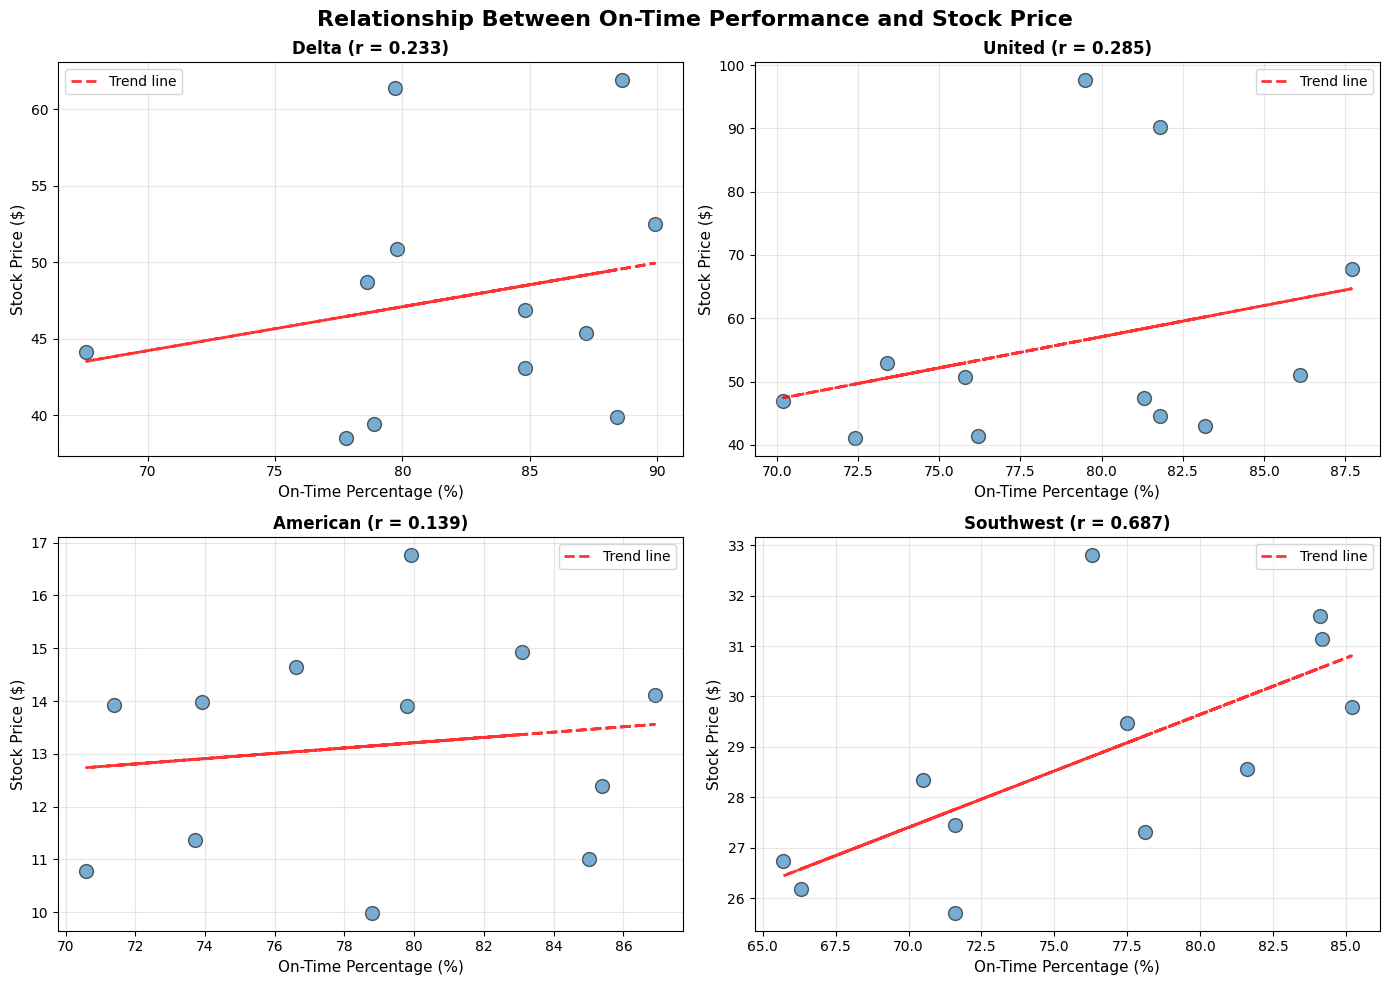

In [27]:
# Scatter Plot to See Correlation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Relationship Between On-Time Performance and Stock Price',
             fontsize=16, fontweight='bold')

for idx, airline in enumerate(airline_tickers.keys()):
    ax = axes[idx // 2, idx % 2]
    data = combined_df[combined_df['Airline'] == airline]

    # Create scatter plot
    ax.scatter(data['OnTime_Percentage'], data['Stock_Price'],
               s=100, alpha=0.6, edgecolors='black', linewidth=1)

    # Calculate and display correlation
    correlation = data['OnTime_Percentage'].corr(data['Stock_Price'])

    # Add trend line
    z = np.polyfit(data['OnTime_Percentage'], data['Stock_Price'], 1)
    p = np.poly1d(z)
    ax.plot(data['OnTime_Percentage'], p(data['OnTime_Percentage']),
            "r--", alpha=0.8, linewidth=2, label=f'Trend line')

    ax.set_xlabel('On-Time Percentage (%)', fontsize=11)
    ax.set_ylabel('Stock Price ($)', fontsize=11)
    ax.set_title(f'{airline} (r = {correlation:.3f})', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

Visually, this doesn't really tell us much. Let's look at some numbers.

In [28]:
# Calculate correlation coefficients
for airline in airline_tickers.keys():
    data = combined_df[combined_df['Airline'] == airline]
    correlation = data['Stock_Price'].corr(data['OnTime_Percentage'])
    print(f"{airline}: r = {correlation:.3f}")

Delta: r = 0.233
United: r = 0.285
American: r = 0.139
Southwest: r = 0.687


Now this is interesting. First, a quick refresher on correlation coefficients (variable r). A correlation coefficient measures how much one variable correlates to another. In this case, how much does on-time percentage correlate to stock price. An r of 0 means there is no correlation, and an r of 1 means there is perfect correlation. It's typically accepted that ~.5 and above is a moderate correlation, while .7 and above is considered a strong correlation.
The reason I say this is interesting is that Delta, United, and American have relatively weak correlation between their OTP and stock prices. Southwest on the other hand, has a moderate correlation. Let's consider why this could be.
I mentioned earlier that there's more that goes into an airline than its punctuality. A vast network, airport lounge access, loyalty programs, etc. While Delta, United, and American airlines all have these in droves, those who travel regularly know that Southwest is known for its no-frills, bare-bones approach that allows it (or at least did allow it) to serve as a low-budget airline in the industry. Therefore, with less other factors informing the airline's value, it makes sense that the one and almost only thing it does - fly passengers - would matter more to the company's overall value and thus affect its stock price.

Source for interpretation of the correlation coefficient: https://pmc.ncbi.nlm.nih.gov/articles/PMC6107969/

## 3. Insights and Conclusions

Overall, it would seem that although there is some correlation between on time performance and stock prices, it's rather weak, with one exception: Southwest Airlines. As mentioned earlier, numerous variables play a role in the valuation of company and thus their stock prices. While Delta or United may be evaluated on their punctuality to an extent, customers and thus shareholders also case about the overall experience they provide. Nice airport lounges, rewarding loyalty programs, vast travel networks, exclusive partnerships with strategic businesses, newer planes, etc. may overshadow the occasional delay, especially if these delays are not the fault of the airline. As we saw with the on time performance line plot, every airline was affected practically equally by delays which suggests that most delays are not the fault of the airlines themselves, but likely other factors that affect all airlines. The true insight that I see here is that each airline is a unique business, and must thus be evaluated as such. Perhaps if I was in Southwest's shoes, I'd consider expanding my business model to include these other factors that inform my stock price; after all, it's a tenuous position to lead a company where your stock price fluctuates with delays, which are presumably not your fault most of the time. Conversely, if I'm in the shoes of Delta, United, or American Airlines, I'd continue to focus on investing in my overall user experience. If faced with a choice of implementing a system that results in a slight increase of on time performance, I may choose to not pursue that and instead place those resources into something customer-facing.


## 4. Personal Reflection

Growing up as a kid, I've always been fascinated by flying. It's what got me into the aviation industry to begin with and why I became a pilot. Even now as an adult, the industry fascinates me and is ripe for data analysis. I find the differences between airlines and how they go about business and carving out their unique section in the industry to be interesting. As a pilot myself, I know firsthand that most delays are not usually the fault of those operating the flight. Instead things like weather, air traffic control, unforeseen maintenance issues, etc. are all usually the culprit. I wondered from a business perspective how big of a deal this really was, and that's what inspired me to look into this data set.
What surprised me the most was how correlated OTP was to Southwest's stock performance. Even though they are known in the industry as the low-budget airline and they pride themselves on being efficient and just focusing on getting passengers from A to B safely, I would still think that the correlation would be relatively weak similar to other airlines.
Knowing what we know now, however, I'd love to continue exploring how other factors influence the company's performance.